In [1]:
#%pylab inline

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
#  Important !!!! path to shared tensorflow dataset
eagle_dir='/storage/scratch/mhuertas/data/sfh/tensorflow_datasets/eagle'
tng_dir='/storage/scratch/mhuertas/data/sfh/tensorflow_datasets/tng100'

#data_dir ='/scratch/mhuertas/tensorflow_datasets/eagle'

# Load Datasets

In [2]:
from sfh.datasets.eagle import eagle
from sfh.datasets.tng100 import tng100

In [3]:
dset_eagle = tfds.load('eagle', split='train', data_dir=eagle_dir)
dset_tng = tfds.load('tng100', split='train', data_dir=tng_dir)

2022-04-14 14:14:27.033098: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 14:14:28.598572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11314 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:02:00.0, compute capability: 6.0
2022-04-14 14:14:28.599194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11238 MB memory:  -> device: 1, name: Tesla P100-PCIE-12GB, pci bus id: 0000:83:00.0, compute capability: 6.0


# Plot some examples 

Train 7314
tf.Tensor(
[ 1498.5  1535.1  2057.9  2226.5  2246.9  2297.7  2300.7  2372.5  2582.5
  2601.   2710.1  2797.1  2994.3  3355.1  3359.2  3478.5  3556.5  3584.7
  3602.5  3828.   3924.4  4107.9  4311.7  4318.1  4326.5  4370.9  4418.6
  4433.5  4448.   4555.6  4665.3  4702.5  4744.3  4753.2  4760.9  4773.7
  4800.9  4810.   4869.9  5308.2  5359.5  5438.9  5459.   5470.2  5477.5
  5536.1  5887.4  5912.4  5996.8  6170.   6175.6  6244.9  6275.5  6310.5
  6362.6  6564.6  6576.9  6616.   6781.4  6936.4  7489.9  7520.   7648.5
  7671.3  7675.7  7693.3  7750.1  7891.1  7985.6  8012.3  8029.5  8059.6
  8166.   8660.   8826.3  8871.7  8946.8  9006.2  9054.5  9096.4  9129.
  9153.7  9168.9  9620.   9862.9  9907.8 10209.8 10314.1 10459.4 10550.7
 11248.6 11485.  11534.4 11945.1 12387.7 12486.1 12500.9 12524.7 12776.9
 13923.9 14983.9 15370.8 15600.8 16060.4 16359.1 16430.6 16488.9 17063.3
 19858.2 21524.7 21621.6 21635.6 21684.6 22084.  27759.2 33682.1 34799.8
 35511.  35569.7 38275.  44330

2022-04-14 14:14:29.369644: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-14 14:14:29.460115: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


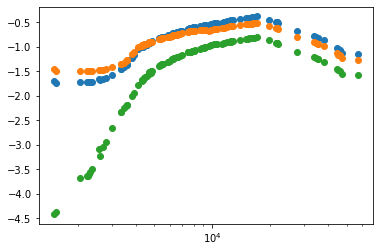

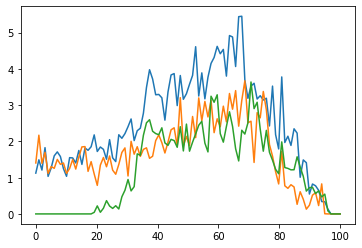

In [4]:
import matplotlib.pyplot as plt
import numpy as np
print("Train",len(dset_eagle))

fig, axs = plt.subplots(1, 1)
for example in dset_eagle.take(3):
    #print((example['wl_sort'])[example['inds_valid']])
    inds_valid = example['inds_valid']
    axs.scatter((example['wl_sort'])[example['inds_valid']],np.log10(example['sed']))
    axs.set_xscale('log')

fig, axs = plt.subplots(1, 1)
for example in dset_eagle.take(3):
    #print(wl[example['inds_valid']])
    axs.plot(example['time'],example['SFR_Max'])
    #axs.set_xscale('log')    
    #sed = (tf.gather(example['sed'],inds, axis=1) + 20.70243)/2.0466275

Train 12326
tf.Tensor(
[ 1498.5  1535.1  2057.9  2226.5  2246.9  2297.7  2300.7  2372.5  2582.5
  2601.   2710.1  2797.1  2994.3  3355.1  3359.2  3478.5  3556.5  3584.7
  3602.5  3828.   3924.4  4107.9  4311.7  4318.1  4326.5  4370.9  4418.6
  4433.5  4448.   4555.6  4665.3  4702.5  4744.3  4753.2  4760.9  4773.7
  4800.9  4810.   4869.9  5308.2  5359.5  5438.9  5459.   5470.2  5477.5
  5536.1  5887.4  5912.4  5996.8  6170.   6175.6  6244.9  6275.5  6310.5
  6362.6  6564.6  6576.9  6616.   6781.4  6936.4  7489.9  7520.   7648.5
  7671.3  7675.7  7693.3  7750.1  7891.1  7985.6  8012.3  8029.5  8059.6
  8166.   8660.   8826.3  8871.7  8946.8  9006.2  9054.5  9096.4  9129.
  9153.7  9168.9  9620.   9862.9  9907.8 10209.8 10314.1 10459.4 10550.7
 11248.6 11485.  11534.4 11945.1 12387.7 12486.1 12500.9 12524.7 12776.9
 13923.9 14983.9 15370.8 15600.8 16060.4 16359.1 16430.6 16488.9 17063.3
 19858.2 21524.7 21621.6 21635.6 21684.6 22084.  27759.2 33682.1 34799.8
 35511.  35569.7 38275.  4433

2022-04-14 14:14:30.749309: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


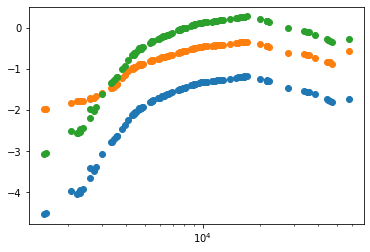

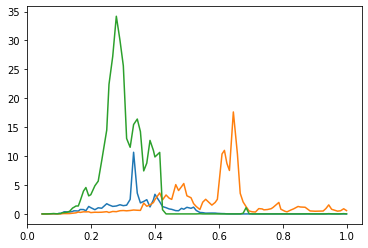

In [5]:
import matplotlib.pyplot as plt
print("Train",len(dset_tng))

fig, axs = plt.subplots(1, 1)
for example_tng, example_eagle in zip(dset_tng.take(3),dset_eagle.take(3)):
    #print(wl[example['inds_valid']])
    #print(wl_tng)
    #print(example['sed'])
    print((example_tng['wl_sort'])[example_eagle['inds_valid']])
    axs.scatter((example_tng['wl_sort'])[example_eagle['inds_valid']],np.log10((example_tng['sed'])[example_eagle['inds_valid']]))
    axs.set_xscale('log')

fig, axs = plt.subplots(1, 1)
for example in dset_tng.take(3):
    #print(wl[example['inds_valid']])
    axs.plot(example['time'],example['SFR_Max'])
    #axs.set_xscale('log')    
    #sed = (tf.gather(example['sed'],inds, axis=1) + 20.70243)/2.0466275

# Define datasets for TNG and EAGLE

In [6]:
def preprocessing(example):
    return tf.reshape(example['SFR_Max'],(-1,100,1)), \
           tf.reshape(example['SFR_Max'],(-1,100,1))

def preprocessing_wmass(example):
    mass = example['Mstar'][:,0]
    mass_half = example['Mstar_Half'][:,0]
    tiler = tf.constant([100])
    mass = tf.reshape(tf.tile(mass, tiler),(-1,100,1))
    mass_half = tf.reshape(tf.tile(mass_half, tiler),(-1,100,1))
    sfr = tf.math.add(tf.reshape(example['SFR_Max'],(-1,100,1)), 1e-5)
    res = tf.concat([sfr, mass, mass_half], axis=2)
    return res, res

def preprocessing_wmass_atan(example):
    mass = example['Mstar'][:,0]
    #mass_half = example['Mstar_Half'][:,0]
    #sed = (tf.gather(example['sed'],inds, axis=1) + 20.70243)/2.0466275
    sed = example['sed']
    tiler = tf.constant([100])
    mass = tf.reshape(tf.tile(mass, tiler),(-1,100,1))
    #mass_half = tf.reshape(tf.tile(mass_half, tiler),(-1,100,1))
    sfr = tf.math.tanh(tf.math.asinh(tf.reshape(example['SFR_Max'],(-1,100,1))/40) + 1e-3 + 0.005*tf.math.softplus(tf.random.normal(shape=[64,100,1])))
    res = tf.concat([sfr], axis=2) #  mass, mass_half
    return (res, sed), res

def input_fn(mode='train', batch_size=64, 
             dataset_name='tng100', data_dir=None,
             include_mass=True, arctan=True):
    """
    mode: 'train' or 'test'
    """
    keys = ['sed','Mstar', 'SFR_Max', 'mass_quantiles', 'sed', 'time']
    if mode == 'train':
        dataset = tfds.load(dataset_name, split='train[:90%]', data_dir=data_dir)
        dataset = dataset.map(lambda x: {k:x[k] for k in keys})
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load(dataset_name, split='train[90%:]', data_dir=data_dir)
        dataset = dataset.map(lambda x: {k:x[k] for k in keys}) #dataset = dataset.repeat()
        
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if include_mass and arctan:
        dataset = dataset.map(preprocessing_wmass_atan) # Apply data preprocessing
    elif include_mass:
        dataset = dataset.map(preprocessing_wmass)
    else : 
        dataset = dataset.map(preprocessing)
    dataset = dataset.prefetch(-1)       # fetch next batches while training current one (-1 for autotune)
    return dataset

In [7]:
def preprocessing(example):
    return tf.reshape(example['SFR_Max'],(-1,100,1)), \
           tf.reshape(example['SFR_Max'],(-1,100,1))

def preprocessing_wmass(example):
    mass = example['Mstar'][:,0]
    mass_half = example['Mstar_Half'][:,0]
    tiler = tf.constant([100])
    mass = tf.reshape(tf.tile(mass, tiler),(-1,100,1))
    mass_half = tf.reshape(tf.tile(mass_half, tiler),(-1,100,1))
    sfr = tf.math.add(tf.reshape(example['SFR_Max'],(-1,100,1)), 1e-5)
    res = tf.concat([sfr, mass, mass_half], axis=2)
    return res, res

def preprocessing_wmass_atan_tng(example):
    mass = example['Mstar'][:,0]
    #mass_half = example['Mstar_Half'][:,0]
    sed = (tf.gather(example['sed'],np.squeeze(np.where(inds_valid)), axis=1))
    #sed = example['sed']
    tiler = tf.constant([100])
    mass = tf.reshape(tf.tile(mass, tiler),(-1,100,1))
    #mass_half = tf.reshape(tf.tile(mass_half, tiler),(-1,100,1))
    sfr = tf.math.tanh(tf.math.asinh(tf.reshape(example['SFR_Max'],(-1,100,1))/40) + 1e-3 + 0.005*tf.math.softplus(tf.random.normal(shape=[64,100,1])))
    res = tf.concat([sfr], axis=2) #  mass, mass_half
    return (res, sed), res

def input_fn_tng(mode='train', batch_size=64, 
             dataset_name='tng100', data_dir=None,
             include_mass=True, arctan=True):
    """
    mode: 'train' or 'test'
    """
    keys = ['sed','Mstar', 'SFR_Max', 'mass_quantiles', 'sed', 'time']
    if mode == 'train':
        dataset = tfds.load(dataset_name, split='train[:90%]', data_dir=data_dir)
        dataset = dataset.map(lambda x: {k:x[k] for k in keys})
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load(dataset_name, split='train[90%:]', data_dir=data_dir)
        dataset = dataset.map(lambda x: {k:x[k] for k in keys}) #dataset = dataset.repeat()
        
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if include_mass and arctan:
        dataset = dataset.map(preprocessing_wmass_atan_tng) # Apply data preprocessing
    elif include_mass:
        dataset = dataset.map(preprocessing_wmass)
    else : 
        dataset = dataset.map(preprocessing)
    dataset = dataset.prefetch(-1)       # fetch next batches while training current one (-1 for autotune)
    return dataset

In [8]:
batch_size = 64
epochs = 10

dtrain_eagle = input_fn(mode='train', batch_size=batch_size, dataset_name='eagle',data_dir=eagle_dir)
dval_eagle = input_fn(mode='val', batch_size=batch_size, dataset_name='eagle',data_dir=eagle_dir)

In [9]:
batch_size = 64
epochs = 10

dtrain_tng = input_fn_tng(mode='train', batch_size=batch_size, dataset_name='tng100',data_dir=tng_dir)
dval_tng = input_fn_tng(mode='val', batch_size=batch_size, dataset_name='tng100',data_dir=tng_dir)

# Train on TNG100

In [10]:
""""Keras model implementing PixelCNN."""

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
import sys
import time
tfd = tfp.distributions
tfb = tfp.bijectors
tfkl=keras.layers

def generate_model(n_timesteps, n_filters, *, n_channels=1, n_components=2, kernel_size=3,
                   n_dilations=5, list_of_dilation_rates=None,
                   list_of_filters=None):
    """Generate the PixelCNN Keras model.

    Parameters
    ----------
    n_timesteps : int
        Number of time steps.
    n_filters : int
        Number of filters.
    n_channels : int, default 1
        Number of channels in the dataset
    n_components : int, default 2
        Number of components in the Gaussian mixture distribution.
    kernel_size : int, default 3
        Size of the convolution kernel.
    n_dilations : int, default 5
        Number of dilated convolutions to do. For each convolution, the
        dilation rate is 2**idx+1 and the number of filters is 2**idx+4.
    list_of_dilation_rates : list of int or None, default None
        List of the dilation rates to use in the dilated convolutions. If not
        None, the n_dilations is not used and filters must be given with the
        same size.
    list_of_filters : list of int or None, default None
        List of the filter number for each of the dilated convolutions. Must be
        of the same size as list_of_dilation_rates

    Returns
    -------
    Keras model

    """
    # Shape of the distribution
    event_shape = [1]
    # Compute how many parameters this distribution requires
    params_size = 2
    #print(params_size)

    
    input_sfh = keras.layers.Input(shape=(n_timesteps,1))
    input_sed = keras.layers.Input(shape=(n_filters,1))
    
    # Compress the SED and return some channels
    sed_net = tf.keras.Sequential([
        tfkl.Input(shape=(125, 1)),
        tfkl.Conv1D(16, 3, strides=2, padding='same', activation='relu'),
        tfkl.Conv1D(32, 3, strides=2, padding='same', activation='relu'),
        tfkl.Conv1D(64, 3, strides=2, padding='same', activation='relu'),
        tfkl.Conv1D(64, 3, strides=1, padding='same', activation='relu'),
        tfkl.Flatten(),
        tfkl.Dense(128, activation='relu'),
        tfkl.Dense(8, activation='softplus'),
        tfkl.Lambda(lambda x: tf.tile(tf.reshape(x,[-1,1,8]), [1,100,1]))
        ])
    
    merged = keras.layers.Concatenate(axis=-1)([input_sfh, 
                                                sed_net(input_sed)])
    
    
    # Shift and cut
    net = keras.layers.Lambda(
            lambda x: tf.pad(x, paddings=tf.constant([[0, 0], [1, 0], [0, 0]]))
        )(merged)
    
    net=keras.layers.Lambda(
            lambda x: x[:, :-1, :]
        )(net)
    

    net=keras.layers.Conv1D(
            filters=16,
            kernel_size=kernel_size,
            dilation_rate=1,
            padding='causal',
            activation='relu'
        )(net)

    if list_of_dilation_rates is None:
        list_of_dilation_rates = [2**(i+1) for i in range(n_dilations)]
        list_of_filters = [2**(i+4) for i in range(n_dilations)]
    elif len(list_of_filters) != len(list_of_dilation_rates):
        raise ValueError(
            "filters and list_of_dilation_rates must have the same length")

    for dilation_rate, nb_filters in zip(list_of_dilation_rates,
                                         list_of_filters):
        net = keras.layers.Conv1D(
                filters=nb_filters,
                kernel_size=kernel_size,
                dilation_rate=dilation_rate,
                padding='causal',
                activation='relu')(net)
    
    net = keras.layers.Dense(2)(net)
    
    net = tfp.layers.DistributionLambda(
                    make_distribution_fn=lambda t: tfd.Beta(
                          concentration1=tf.math.softplus(t[..., 0])+1e-3,
                          concentration0=tf.math.softplus(t[..., 1])+1e-3)
                    )(net)
    
    pixel_cnn = keras.models.Model(inputs=[input_sfh, input_sed],
                                  outputs=net)

    # Use the negative log-likelihood as loss function.
    def negloglik(y, q):
        return tf.reduce_sum(-q.log_prob(y[...,0]), -1)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002)
    pixel_cnn.compile(loss=negloglik, optimizer=opt)

    return pixel_cnn

In [11]:
pixel_cnn = generate_model(100,125)

pixel_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 125, 1)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 sequential (Sequential)        (None, 100, 8)       152424      ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 100, 9)       0           ['input_1[0][0]',                
                                                                  'sequential[0][0]']         

2022-04-14 14:14:32.927325: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [12]:
hist = pixel_cnn.fit(dtrain_tng, 
                     epochs=epochs,
                     steps_per_epoch=1000,validation_data=dval_tng)

Epoch 1/10


2022-04-14 14:14:37.854301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


 996/1000 [============================>.] - ETA: 0s - loss: -254.4707WARNING:tensorflow:@custom_gradient grad_fn has 'variables' in signature, but no ResourceVariables were used on the forward pass.


1000/1000 [==============================] - 20s 13ms/step - loss: -254.5900 - val_loss: -286.2555
Epoch 2/10
1000/1000 [==============================] - 12s 12ms/step - loss: -304.6505 - val_loss: -316.2079
Epoch 3/10
1000/1000 [==============================] - 12s 12ms/step - loss: -324.1758 - val_loss: -329.1727
Epoch 4/10
1000/1000 [==============================] - 12s 12ms/step - loss: -334.0952 - val_loss: -335.4442
Epoch 5/10
1000/1000 [==============================] - 12s 12ms/step - loss: -338.2293 - val_loss: -338.8752
Epoch 6/10
1000/1000 [==============================] - 12s 12ms/step - loss: -340.6678 - val_loss: -340.6627
Epoch 7/10
1000/1000 [==============================] - 12s 12ms/step - loss: -342.1778 - val_loss: -340.5334
Epoch 8/10
1000/1000 [==============================] - 12s 12ms/step - loss: -342.8707 - val_loss: -341.0817
Epoch 9/10
1000/1000 [==============================] - 12s 12ms/step - loss: -343.5297 - val_loss: -343.1888
Epoch 10/10
1000/1000

# Test on TNG100

In [13]:
dset_test = dval_tng.as_numpy_iterator()

In [14]:
data = next(dset_test)

In [15]:
ind=55
sample = np.zeros([64,100,1])
true = data[0][0][ind,:,0]
sed = data[0][1][ind].reshape([1,125,1]).repeat(64,axis=0)
# init at the 
sample[:,0,0] = true[0]

In [16]:
for i in range(99):
    tmp = pixel_cnn((sample, sed)).sample()
    sample[:,i+1,0] = tmp[:,i+1]

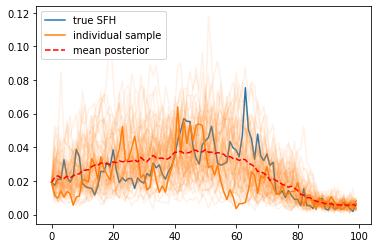

In [17]:
plt.plot(true,label='true SFH')
for i in range(64):
    plt.plot(sample[i,:,0],color='C1',alpha=0.1)
plt.plot(sample[1,:,0],color='C1',alpha=1.,label='individual sample')    
plt.plot(sample.mean(axis=0)[:,0],'--',color='red',label='mean posterior')
plt.legend(loc='upper left')

# Test on EAGLE

In [18]:
dset_eagle = dval_eagle.as_numpy_iterator()

In [19]:
data = next(dset_eagle)

In [20]:
ind=55
sample = np.zeros([64,100,1])
true = data[0][0][ind,:,0]
sed = data[0][1][ind].reshape([1,125,1]).repeat(64,axis=0)
# init at the 
sample[:,0,0] = true[0]

In [21]:
for i in range(99):
    tmp = pixel_cnn((sample, sed)).sample()
    sample[:,i+1,0] = tmp[:,i+1]

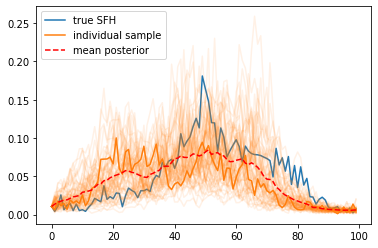

In [22]:
plt.plot(true,label='true SFH')
for i in range(64):
    plt.plot(sample[i,:,0],color='C1',alpha=0.1)
plt.plot(sample[1,:,0],color='C1',alpha=1.,label='individual sample')    
plt.plot(sample.mean(axis=0)[:,0],'--',color='red',label='mean posterior')
plt.legend(loc='upper left')